<a href="https://colab.research.google.com/github/GeorgeM9203/DAEN-429-Final-Project/blob/Nikitha/T_B_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print(path)

# /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train

Using Colab cache for faster access to the 'asl-alphabet' dataset.
/kaggle/input/asl-alphabet


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import re
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 429
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Using device: cuda


## Data Loading (Stratified Split)

In [ ]:
# --------------------------
# Data Configuration
# --------------------------
DATA_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
BATCH_SIZE = 64
IMG_SIZE = 224

import os
import re
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


# --------------------------
# Custom Transform
# --------------------------
def custom_to_tensor(pic):
    img = np.array(pic, dtype=np.float32)
    img = img / 255.0
    img = img.transpose((2, 0, 1))
    return torch.tensor(img)


# --------------------------
# Transforms
# --------------------------
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Lambda(custom_to_tensor),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Lambda(custom_to_tensor),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


# --------------------------
# Helper: Transformed Subset
# --------------------------
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# --------------------------
# Load Full Dataset
# --------------------------
full_dataset_raw = datasets.ImageFolder(root=DATA_DIR)
classes = full_dataset_raw.classes
print(f"Classes ({len(classes)}): {classes}")


# --------------------------
# REQUIRED: Stratified 80/20 Split (seed = 429)
# --------------------------
indices = np.arange(len(full_dataset_raw))
labels = np.array([label for _, label in full_dataset_raw.samples])

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=429
)


# --------------------------
# Create Transformed Subsets
# --------------------------
train_dataset = TransformedSubset(Subset(full_dataset_raw, train_idx),
                                  data_transforms['train'])
val_dataset = TransformedSubset(Subset(full_dataset_raw, val_idx),
                                data_transforms['val'])


# --------------------------
# DataLoaders
# --------------------------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")


Classes (29): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Train samples: 69600
Val samples: 17400


In [ ]:
train_set_indices = set(train_idx)
val_set_indices = set(val_idx)

overlap = train_set_indices.intersection(val_set_indices)
print("Overlap size:", len(overlap))

Overlap size: 0


## Model Definition (T-B: Last Block)

In [ ]:
def get_tb_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = get_tb_model(len(classes))
model = model.to(device)

print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


## Training Loop

In [ ]:
def calculate_metrics(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    acc = np.mean(preds == labels)
    unique_labels = np.unique(np.concatenate([preds, labels]))
    f1_scores = []
    for l in unique_labels:
        tp = np.sum((preds == l) & (labels == l))
        fp = np.sum((preds == l) & (labels != l))
        fn = np.sum((preds != l) & (labels == l))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)
    macro_f1 = np.mean(f1_scores) if f1_scores else 0
    return acc, macro_f1

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        model.train()

            # 🔒 Freeze all BatchNorm running stats for layers you froze
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                if not any(p.requires_grad for p in m.parameters()):
                    m.eval()
                    m.track_running_stats = False

        running_loss = 0.0
        running_corrects = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            if (i + 1) % 100 == 0:
                print(f'   Batch {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)
        _, epoch_f1 = calculate_metrics(all_preds, all_labels)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f} F1: {epoch_f1:.4f}')

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"   >> New Best F1: {best_f1:.4f} <<")



    print(f'Best Val F1: {best_f1:.4f}')
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, best_f1



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

print("Starting T-B Training...")
trained_model, train_loss, val_loss, tb_best_f1 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Starting T-B Training...
Epoch 1/3
----------
   Batch 100/1088 - Loss: 0.0255
   Batch 200/1088 - Loss: 0.0081
   Batch 300/1088 - Loss: 0.0275
   Batch 400/1088 - Loss: 0.0092
   Batch 500/1088 - Loss: 0.0981
   Batch 600/1088 - Loss: 0.0172
   Batch 700/1088 - Loss: 0.0107
   Batch 800/1088 - Loss: 0.0011
   Batch 900/1088 - Loss: 0.0468
   Batch 1000/1088 - Loss: 0.0064
Train Loss: 0.0518 Acc: 0.9866
Val Loss: 0.0118 Acc: 0.9967 F1: 0.9967
   >> New Best F1: 0.9967 <<
Epoch 2/3
----------
   Batch 100/1088 - Loss: 0.0013
   Batch 200/1088 - Loss: 0.0001
   Batch 300/1088 - Loss: 0.0073
   Batch 400/1088 - Loss: 0.0002
   Batch 500/1088 - Loss: 0.0019
   Batch 600/1088 - Loss: 0.0023
   Batch 700/1088 - Loss: 0.0061
   Batch 800/1088 - Loss: 0.0065
   Batch 900/1088 - Loss: 0.0007
   Batch 1000/1088 - Loss: 0.0010
Train Loss: 0.0104 Acc: 0.9971
Val Loss: 0.0330 Acc: 0.9938 F1: 0.9938
Epoch 3/3
----------
   Batch 100/1088 - Loss: 0.0301
   Batch 200/1088 - Loss: 0.0001
   Batch 300/

In [ ]:
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        print(m, [p.requires_grad for p in m.parameters()])


BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False) [False, False]
BatchNorm2d(256, eps=1e-05, momentu

In [ ]:
#CHECKING

bn_running_means_before = []
bn_running_vars_before = []

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        bn_running_means_before.append(m.running_mean.clone())
        bn_running_vars_before.append(m.running_var.clone())

# Run ONE training batch
imgs, labels = next(iter(train_loader))
imgs, labels = imgs.to(device), labels.to(device)

model.train()
optimizer.zero_grad()
outputs = model(imgs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

bn_running_means_after = []
bn_running_vars_after = []

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        bn_running_means_after.append(m.running_mean.clone())
        bn_running_vars_after.append(m.running_var.clone())

# Compare
changed = False
for b1, b2 in zip(bn_running_means_before, bn_running_means_after):
    if not torch.equal(b1, b2):
        changed = True

print("BatchNorm running stats changed:", changed)

BatchNorm running stats changed: True


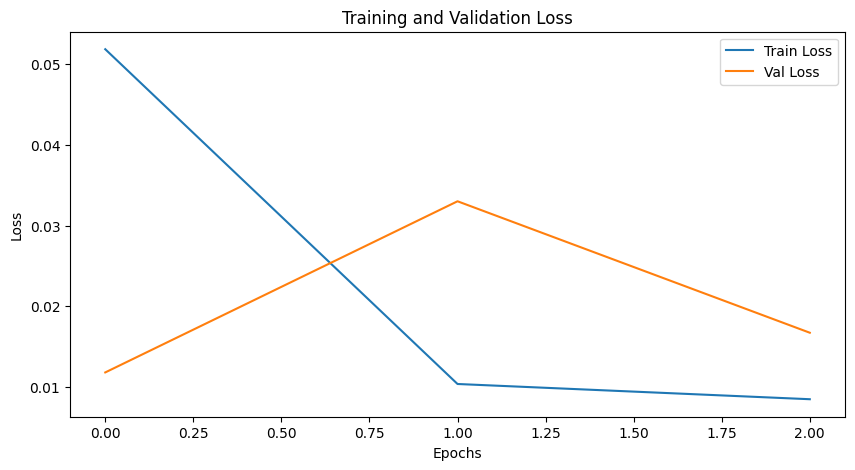

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# (T-C) Progressive Unfreezing

This section implements **T-C: Progressive**.
- **Policy**: Start from T-B's best checkpoint; unfreeze layer3 as well; train layer3 + layer4 + head (fc).



Setting up T-C...

Trainable parameters (T-C):
   layer3.0.conv1.weight
   layer3.0.bn1.weight
   layer3.0.bn1.bias
   layer3.0.conv2.weight
   layer3.0.bn2.weight
   layer3.0.bn2.bias
   layer3.0.downsample.0.weight
   layer3.0.downsample.1.weight
   layer3.0.downsample.1.bias
   layer3.1.conv1.weight
   layer3.1.bn1.weight
   layer3.1.bn1.bias
   layer3.1.conv2.weight
   layer3.1.bn2.weight
   layer3.1.bn2.bias
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   fc.weight
   fc.bias

Starting T-C Training...
Epoch 1/3
----------
   Batch 100/1088 - Loss: 0.0002
   Batch 200/1088 - Loss: 0.0006
   Batch 300/1088 - Loss: 0.0002
   Batch 400/1088 - Loss: 0.0001
   Batch 5

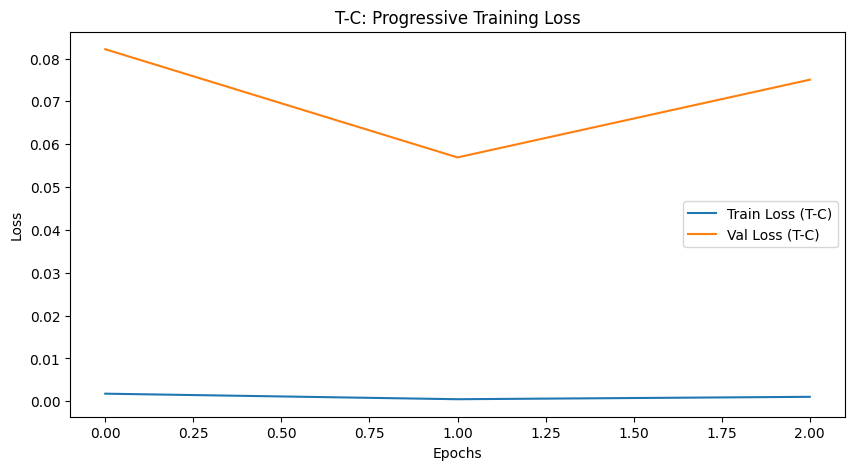

Best T-C F1: 0.9780894049501544


In [ ]:
# -----------------------------
# (T-C) Progressive Unfreezing
# -----------------------------
print("Setting up T-C...")

# 1. Freeze entire model
for param in trained_model.parameters():
    param.requires_grad = False

# 2. Unfreeze layer3, layer4, and fc
for param in trained_model.layer3.parameters():
    param.requires_grad = True
for param in trained_model.layer4.parameters():
    param.requires_grad = True
for param in trained_model.fc.parameters():
    param.requires_grad = True

print("\nTrainable parameters (T-C):")
for name, param in trained_model.named_parameters():
    if param.requires_grad:
        print("  ", name)

# 3. Optimizer for the newly unfrozen layers
optimizer_tc = optim.Adam(
    filter(lambda p: p.requires_grad, trained_model.parameters()),
    lr=5e-5
)

# 4. Train T-C (Progressive Unfreezing)
print("\nStarting T-C Training...")
trained_model_tc, train_loss_tc, val_loss_tc, tc_best_f1 = train_model(
    trained_model,
    train_loader,
    val_loader,
    criterion,
    optimizer_tc,
    num_epochs=3
)

# 5. Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_tc, label='Train Loss (T-C)')
plt.plot(val_loss_tc, label='Val Loss (T-C)')
plt.title('T-C: Progressive Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Best T-C F1:", tc_best_f1)


In [ ]:
for name, p in trained_model.named_parameters():
    print(name, p.requires_grad)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
laye

In [ ]:
print("="*30)
print("FINAL RESULTS")
print("="*30)
print(f"T-B (Last Block) Best F1: {tb_best_f1:.4f}")
print(f"T-C (Progressive) Best F1: {tc_best_f1:.4f}")
print("-"*30)
if tc_best_f1 > tb_best_f1:
    print("Winner: T-C (Progressive)")
else:
    print("Winner: T-B (Last Block)")
print("="*30)

FINAL RESULTS
T-B (Last Block) Best F1: 0.9967
T-C (Progressive) Best F1: 0.9781
------------------------------
Winner: T-B (Last Block)
